## About the dataset

**carat**: Weight of the diamond (continuous) - *Numeric*  
**cut**: Quality of the cut (Fair → Ideal) -	*Categorical*  
**colorDiamond**: Color, from J (worst) to D (best) - *Categorical*  
**clarity**: Clarity grade (I1 worst → IF best) - *Categorical*  
**depth**: Total depth percentage (z / mean(x, y)) - *Numeric*  
**table**: Width of the top of the diamond	- *Numeric*  
**price**: Price in US dollars - *Numeric*  
**x, y, z**: Dimensions in mm (length, width, depth) - *Numeric*  

In [2]:
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"

# See available datasets
print(sns.get_dataset_names())

# Load one
df_diamonds = sns.load_dataset('diamonds')

df_diamonds.head()
df_diamonds.info()

['anagrams', 'anscombe', 'attention', 'brain_networks', 'car_crashes', 'diamonds', 'dots', 'dowjones', 'exercise', 'flights', 'fmri', 'geyser', 'glue', 'healthexp', 'iris', 'mpg', 'penguins', 'planets', 'seaice', 'taxis', 'tips', 'titanic']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


In [3]:
missing_percentage = (df_diamonds.isnull().sum() / len(df_diamonds)) * 100

for column, percentage in missing_percentage.items():
    if percentage > 20:
        print(f"\033[91m\033[1m{column}: {percentage:.2f}% missing\033[0m")
    elif percentage > 5:
        print(f"\033[93m{column}: {percentage:.2f}% missing\033[0m")
    elif percentage > 0.00:
        print(f"\033[92m{column}: {percentage:.2f}% missing\033[0m")
    else:
        print(f"{column}: {percentage:.2f}% missing")
    

carat: 0.00% missing
cut: 0.00% missing
color: 0.00% missing
clarity: 0.00% missing
depth: 0.00% missing
table: 0.00% missing
price: 0.00% missing
x: 0.00% missing
y: 0.00% missing
z: 0.00% missing


In [4]:
dupes = df_diamonds.duplicated().sum()
print(dupes)

146


In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df_encoded = df_diamonds.copy()

# Ordinal encoding
clarity_order = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
cut_order = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}

df_encoded['clarity'] = df_encoded['clarity'].map(clarity_order)
df_encoded['cut'] = df_encoded['cut'].map(cut_order)


df_encoded = pd.get_dummies(df_encoded, columns=['color'], prefix='color')

#Standardize the price
scaler = StandardScaler()
df_encoded["price_scaled"] = scaler.fit_transform(df_encoded[["price"]])
df_features = df_encoded.drop(columns=["price"])

df_features.drop(columns=["x", "y", "z"], inplace=True)
df_features.head()

/opt/anaconda3/envs/AI_lesson1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,carat,cut,clarity,depth,table,color_D,color_E,color_F,color_G,color_H,color_I,color_J,price_scaled
0,0.23,4,1,61.5,55.0,False,True,False,False,False,False,False,-0.904095
1,0.21,3,2,59.8,61.0,False,True,False,False,False,False,False,-0.904095
2,0.23,1,4,56.9,65.0,False,True,False,False,False,False,False,-0.903844
3,0.29,3,3,62.4,58.0,False,False,False,False,False,True,False,-0.902090
4,0.31,1,1,63.3,58.0,False,False,False,False,False,False,True,-0.901839


/opt/anaconda3/envs/AI_lesson1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/AI_lesson1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/AI_lesson1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/AI_lesson1/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of

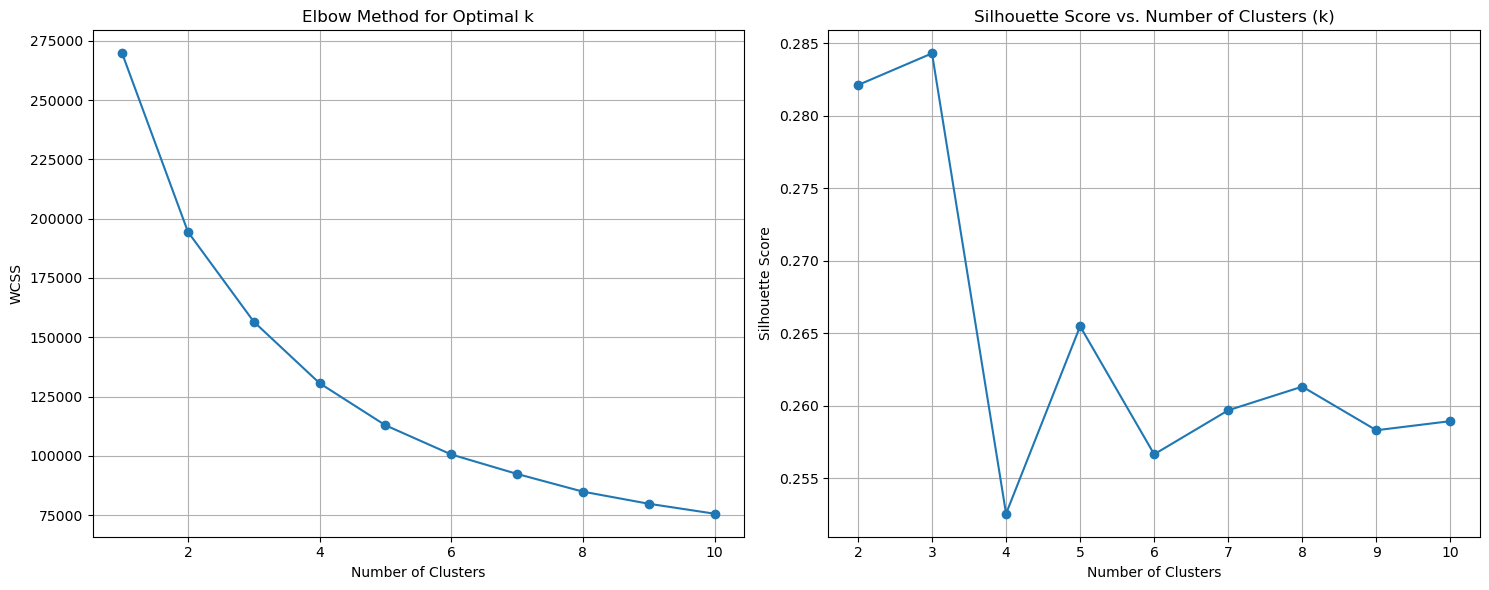

In [16]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Scale the features
X_clusterering_one = df_features[["carat", "depth", "price_scaled", "clarity", "cut"]]

X_scaled = scaler.fit_transform(X_clusterering_one)

# Decide on the number of clusters
wcss = []
scores = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    if i > 1:  # Silhouette score is not defined for 1 cluster
        labels = kmeans.predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        scores.append(score)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Elbow Method
axes[0].plot(range(1, 11), wcss, marker='o')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('WCSS')
axes[0].grid(True)

# Plot Silhouette Score (only for k > 1)
axes[1].plot(range(2, 11), scores, marker='o')
axes[1].set_title('Silhouette Score vs. Number of Clusters (k)')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()
